<font size=7> Create CA1 Dataset

<font color="green">

**Current Progress**

We currently are able to download the dataset, however, it takes up a lot of space. 34gb to be exact. Doing the analysis quickly eats up all of the remaining memory. Thus we should be selected about what we are running the LFP on. We consider only a subset of the recording.

## Look at Spike Data

We look at the spike data to determine what would be a good portion of the recordign to zoom in on for the raw data

In [3]:
from human_hip.basics import read_phy_files,  raster_fancy_plot
sd = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')

The first 20 seconds of the recording are a time of strong activity. Also, after the 20 second mark, there is a strange artifact. **Thuse we use only the first 20 seconds for our intial analysis of the raw data**

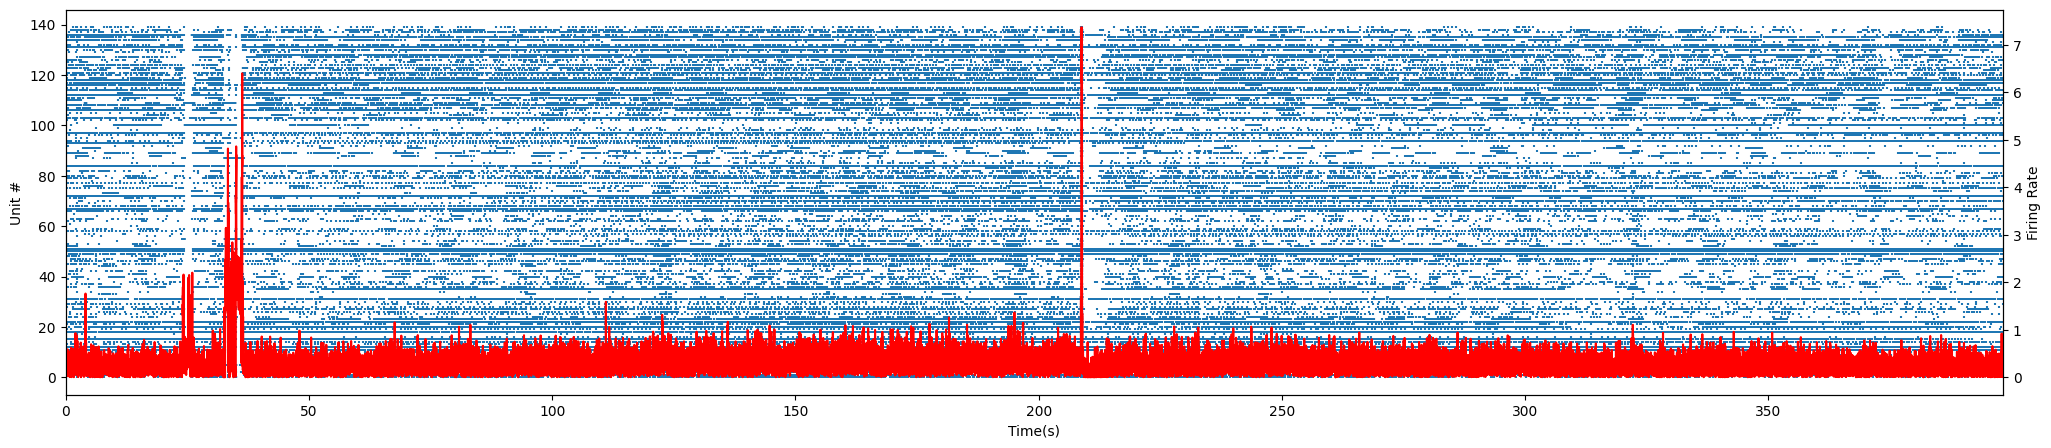

In [7]:
raster_fancy_plot(sd, xsize=25, ysize=5)

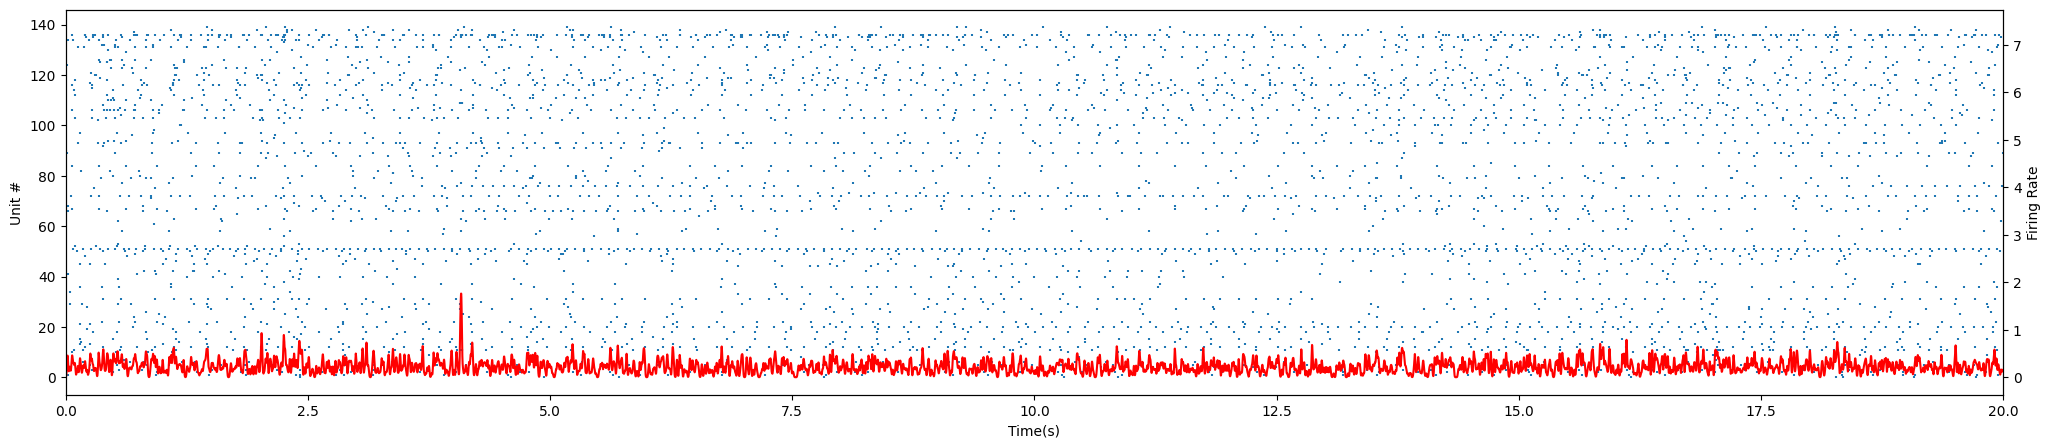

In [8]:
raster_fancy_plot(sd, xsize=25, ysize=5, start_time=0, stop_time=20)

## Download Data Locally

`ls` command

```
aws --endpoint https://s3.braingeneers.gi.ucsc.edu s3 ls s3://braingeneers/ephys/2023-04-02-e-hc328_unperturbed/
```

`cp` command

```
aws --endpoint https://s3.braingeneers.gi.ucsc.edu s3 cp s3://braingeneers/ephys/2023-04-02-e-hc328_unperturbed . --recursive
```

<font color="red"> the recursive cp command didn't work the first time, so I install the necessary files one by one

```
aws --endpoint https://s3.braingeneers.gi.ucsc.edu s3 cp s3://braingeneers/ephys/2023-04-02-e-hc328_unperturbed/metadata.json .
```

## Load Data into Python

import stuff

In [9]:
import braingeneers
from braingeneers import analysis
import braingeneers.data.datasets_electrophysiology as ephys

load metadata

In [12]:
braingeneers.set_default_endpoint("/workspaces/human_hippocampus/data")
metadata = ephys.load_metadata("2023-04-02-e-hc328_unperturbed")

load data into python

In [13]:
raw_data = ephys.load_data( metadata=metadata, experiment="experiment1", length=-1, channels=None )

/srv/conda/envs/notebook/lib/python3.10/site-packages/braingeneers/data/datasets_electrophysiology.py:197: UserWarning: Dataset 2023-04-02-e-hc328_unperturbed is not in row-major format, the parallel data reader can't be used, read speeds may be slow over a network.
  warnings.warn(f'Dataset {batch_uuid} is not in row-major format, the parallel data reader '
/srv/conda/envs/notebook/lib/python3.10/site-packages/braingeneers/data/datasets_electrophysiology.py:209: UserWarning: Metadata is missing the required voltage_scaling_factor attribute. Using default value of 1.0.
  warnings.warn('Metadata is missing the required voltage_scaling_factor attribute. Using default value of 1.0.')


In [5]:
# check data shape is correct #len(raw_data) #check the recording is about the right length len(raw_data[0])/20000

array([399., 394., 401., 395., 401., 394., 404., 395., 400., 395.],
      dtype=float32)

## Downsample data

function to downsample data

In [30]:
from scipy import signal

In [31]:
# Downsample abd remove artifact
def downsample(wav_lfp, dec=20, fs=20000.0):
    wav_data = signal.decimate(wav_lfp, dec)
    return fs/dec, wav_data

In [32]:
decimate = 40
fs= 20000
down_fs = fs/decimate

In [56]:
data_down = []

In [57]:
for i in range(len(raw_data)-4): # we run this loop for all code except the last 4 channels, because they are dummy data
    data_down.append( downsample( raw_data[i, 0:(fs*20)], dec=decimate, fs=fs)[1]  )
data_down = np.array( data_down )

save dataset

In [59]:
import pickle

This line is commented out to make sure we don't accidetly overwrite the data

In [60]:
# with open( '/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/raw_start0s_stop20s_downsampled40frames.pkl' , 'wb') as file:
#     pickle.dump(data_down, file)

check that we can load the data correctly

In [65]:
file = open('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/raw_start0s_stop20s_downsampled40frames.pkl', 'rb')
checkit = pickle.load(file)
file.close()
checkit.shape


(1024, 10000)

##  <font color="red"> Filter Data - Never Done

helper function for filtering data

In [8]:
def butter_filter(data, lowcut=None, highcut=None, fs=20000.0, order=5):
    """
    A digital butterworth filter. Type is based on input value.
    Inputs:
        data: array_like data to be filtered
        lowcut: low cutoff frequency. If None or 0, highcut must be a number.
                Filter is lowpass.
        highcut: high cutoff frequency. If None, lowpass must be a non-zero number.
                 Filter is highpass.
        If lowcut and highcut are both give, this filter is bandpass.
        In this case, lowcut must be smaller than highcut.
        fs: sample rate
        order: order of the filter
    Return:
        The filtered output with the same shape as data
    """

    assert (lowcut not in [None, 0]) or (highcut != None), \
        "Need at least a low cutoff (lowcut) or high cutoff (highcut) frequency!"
    if (lowcut != None) and (highcut != None):
        assert lowcut < highcut, "lowcut must be smaller than highcut"

    if lowcut == None or lowcut == 0:
        filter_type = 'lowpass'
        Wn = highcut / fs * 2
    elif highcut == None:
        filter_type = 'highpass'
        Wn = lowcut / fs * 2
    else:
        filter_type = "bandpass"
        band = [lowcut, highcut]
        Wn = [e / fs * 2 for e in band]

    filter_coeff = signal.iirfilter(order, Wn, analog=False, btype=filter_type, output='sos')
    filtered_traces = signal.sosfiltfilt(filter_coeff, data)
    return filtered_traces

run filter on data

In [9]:
low_cut, high_cut = 0.1, 100
#data_ds = butter_filter(raw_data, low_cut, high_cut)
